# Unit testing

In [1]:
!python test_transport_simulation.py

Registering <function TransportSimulation.get_free_N_to_free_C at 0x7fb0f0341158>
Registering <function TransportSimulation.get_nmol_GDP_C_to_GDP_N at 0x7fb0f0340ea0>
Registering <function TransportSimulation.get_nmol_GDP_N_to_GTP_N at 0x7fb0f0340d08>
Registering <function TransportSimulation.get_nmol_GTP_C_to_GDP_C at 0x7fb0f0340d90>
Registering <function TransportSimulation.get_nmol_GTP_N_to_GTP_C at 0x7fb0f0340e18>
Registering <function TransportSimulation.get_nmol_cargo_bleached at 0x7fb0f0341378>
Registering <function TransportSimulation.get_nmol_complex_C_to_free_C at 0x7fb0f0340f28>
Registering <function TransportSimulation.get_nmol_complex_NPC_to_complex_N_C at 0x7fb0f03412f0>
Registering <function TransportSimulation.get_nmol_complex_NPC_to_free_N at 0x7fb0f0340bf8>
Registering <function TransportSimulation.get_nmol_complex_NPC_traverse at 0x7fb0f0341268>
Registering <function TransportSimulation.get_nmol_complex_N_C_to_complex_NPC at 0x7fb0f03411e0>
Registering <function Tran

# Model variables - legend:

complexL/U - importin-cargo complex, labeled (L) or unlabeled (U) 

freeL/U - free cargo, labeled (L) or unlabeled (U) 

c - concentration

v - volume

C - cytoplasm

N - nucleues

NPC - nuclear pore complex

nmol - number of molecules

M - molar (moles per liter)

L - liter

fL - femtoliter


In [2]:
import importlib
import transport_simulation
from transport_simulation import TransportSimulation
importlib.reload(transport_simulation)
import transport_simulation
from transport_simulation import TransportSimulation


Registering <function TransportSimulation.get_free_N_to_free_C at 0x7ffd6063cb70>
Registering <function TransportSimulation.get_nmol_GDP_C_to_GDP_N at 0x7ffd6063c950>
Registering <function TransportSimulation.get_nmol_GDP_N_to_GTP_N at 0x7ffd6063c7b8>
Registering <function TransportSimulation.get_nmol_GTP_C_to_GDP_C at 0x7ffd6063c840>
Registering <function TransportSimulation.get_nmol_GTP_N_to_GTP_C at 0x7ffd6063c8c8>
Registering <function TransportSimulation.get_nmol_cargo_bleached at 0x7ffd6063cd90>
Registering <function TransportSimulation.get_nmol_complex_C_to_free_C at 0x7ffd6063c9d8>
Registering <function TransportSimulation.get_nmol_complex_NPC_to_complex_N_C at 0x7ffd6063cd08>
Registering <function TransportSimulation.get_nmol_complex_NPC_to_free_N at 0x7ffd6063c6a8>
Registering <function TransportSimulation.get_nmol_complex_NPC_traverse at 0x7ffd6063cc80>
Registering <function TransportSimulation.get_nmol_complex_N_C_to_complex_NPC at 0x7ffd6063cbf8>
Registering <function Tran

# Simulation main code

In [6]:
from matplotlib import pyplot as plt
import numpy as np

def time_series(sim_time_sec, attributes, n_skip=10, dt_sec=1e-3, **kwargs):
  '''
  TODO
  '''
  ts= TransportSimulation(**kwargs)
  ts.bleach_start_time_sec= 100.0
  ts.dt_sec= dt_sec
  n= int(np.ceil(sim_time_sec / ts.dt_sec))
  print(f"Running for n={n} time steps")
  n_frames= int(np.floor(n/n_skip)) + 1 
  c_arrs = {attr: np.zeros(n_frames) for attr in attributes}
  i_frame= 0
  print("Cargo before: {}".format(ts.get_total_cargo_nmol()))
  for i in range(n):
    ts.do_one_time_step()
    if (i % n_skip) == 0:
      for attr in attributes:
        c_arrs[attr][i_frame] = ts.get_nmol(attr)
      i_frame += 1
  print("Cargo after: {}".format(ts.get_total_cargo_nmol()))
  return c_arrs


def plot_simulation_attributes(sim_time_sec, 
                               attributes_list, 
                               dt_sec,
                               n_skip=10, 
                               log=True, 
                               **kwargs):
  def merge_lists(lists):
      return [x for y in lists for x in y]
  attributes= merge_lists(attributes_list)
  assert(len(attributes) == sum([len(x) for x in attributes_list]))
  c = time_series(sim_time_sec, 
                  attributes, 
                  n_skip= n_skip,
                  dt_sec= dt_sec,
                  **kwargs)
  fig, axes= plt.subplots(len(attributes_list),
                          1, 
                          figsize=(10,15), 
                          squeeze= False)
  for cur_attributes, ax in zip(attributes_list, axes[:,0]):
      print(cur_attributes)
      for attr in cur_attributes:
        cur_c= c[attr]
        n_frames= len(cur_c)
        x = np.arange(n_frames) * sim_time_sec / n_frames
        ax.plot(x, cur_c, label=attr)
      if log:
        ax.set_yscale('log')
      ax.set_xlabel("time [sec]")
      ax.set_ylabel("nmol")
      ax.legend()
      if is_log:
        ylim= ax.get_ylim()
        ylim= (10.0, ylim[1])
        ax.set_ylim(ylim)
  return axes, x, c


In [7]:
sim_time_sec= 10.0
RAN_attributes = ['GDP_N', 'GDP_C', 'GTP_N', 'GTP_C']
cargoL_attributes= ['complexL_NPC_C_import', 'complexL_NPC_C_export',
                    'complexL_NPC_N_import', 'complexL_NPC_N_export',
                    'freeL_N', 'freeL_C', 'complexL_C', 'complexL_N']
cargoU_attributes= ['complexU_NPC_C_import', 'complexU_NPC_C_export', 
                    'complexU_NPC_N_import', 'complexU_NPC_N_export',
                    'freeU_N', 'freeU_C', 'complexU_C', 'complexU_N']
c_attributes = ["c_C_M", "c_C_M"]
b_attributes = ['fraction_C_b', "c_C_M", ]
npc_attributes = ['nmol_NPC']
dock_attributes = ['c_C_M', 'fraction_C_b', 'nmol_NPC', 'NPC_dock_capacity']

 

Running for n=10000 time steps
Cargo before: 301100.00000000006
Cargo after: 301099.99999999936
['GDP_N', 'GDP_C', 'GTP_N', 'GTP_C']
['complexL_NPC_C_import', 'complexL_NPC_C_export', 'complexL_NPC_N_import', 'complexL_NPC_N_export', 'freeL_N', 'freeL_C', 'complexL_C', 'complexL_N']
['complexU_NPC_C_import', 'complexU_NPC_C_export', 'complexU_NPC_N_import', 'complexU_NPC_N_export', 'freeU_N', 'freeU_C', 'complexU_C', 'complexU_N']


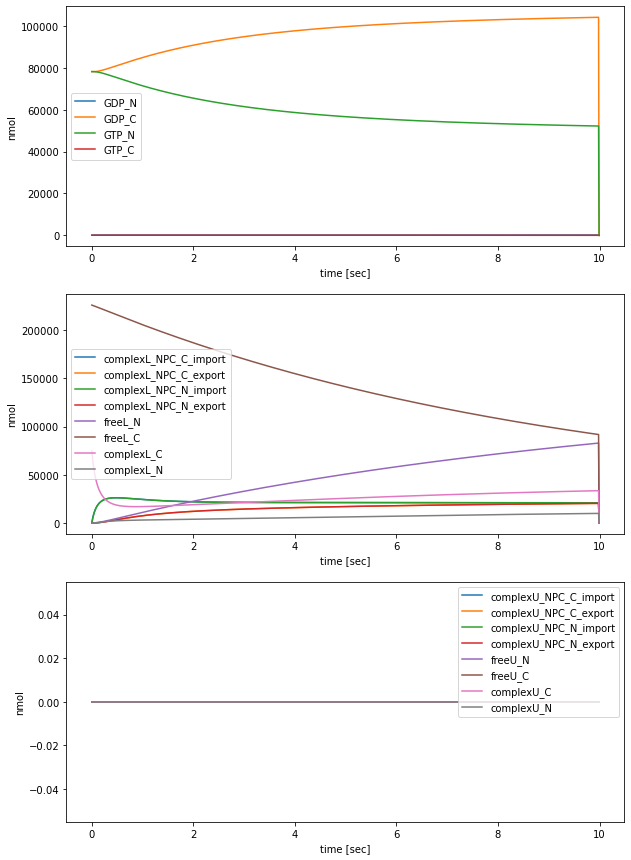

In [8]:
is_log= False
sim_flags= dict()#rate_free_to_complex_per_sec=1.0,
                #max_passive_diffusion_rate_nmol_per_sec_per_M=2e7)
ax, x, c= plot_simulation_attributes(sim_time_sec, 
                           [ RAN_attributes, 
                             cargoL_attributes, 
                             cargoU_attributes ],
                            log= is_log,
                            dt_sec=1e-3,
                            **sim_flags)

[301100. 301100. 301100. 301100. 301100. 301100. 301100. 301100. 301100.
 301100. 301100. 301100. 301100. 301100. 301100. 301100. 301100. 301100.
 301100. 301100. 301100. 301100. 301100. 301100. 301100. 301100. 301100.
 301100. 301100. 301100. 301100. 301100. 301100. 301100. 301100. 301100.
 301100. 301100. 301100. 301100. 301100. 301100. 301100. 301100. 301100.
 301100. 301100. 301100. 301100. 301100. 301100. 301100. 301100. 301100.
 301100. 301100. 301100. 301100. 301100. 301100. 301100. 301100. 301100.
 301100. 301100. 301100. 301100. 301100. 301100. 301100. 301100. 301100.
 301100. 301100. 301100. 301100. 301100. 301100. 301100. 301100. 301100.
 301100. 301100. 301100. 301100. 301100. 301100. 301100. 301100. 301100.
 301100. 301100. 301100. 301100. 301100. 301100. 301100. 301100. 301100.
 301100. 301100. 301100. 301100. 301100. 301100. 301100. 301100. 301100.
 301100. 301100. 301100. 301100. 301100. 301100. 301100. 301100. 301100.
 301100. 301100. 301100. 301100. 301100. 301100. 30

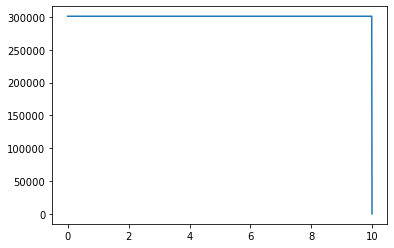

In [9]:
fig,ax= plt.subplots(1,1)

total_cargo= 0.0 * c['complexL_NPC_C_import'] 
for key in c.keys():
    if key.startswith('complex') or key.startswith('free'):
        total_cargo += c[key]
ax.plot(x, total_cargo)
print(total_cargo[1:1000])

#plt.show()
#plt.figure(figsize=(10,5))
#c=plot_simulation_attributes(sim_time_sec, cargoL_attributes, log= is_log)
#plt.show()
#plt.figure(figsize=(10,5))
#c=plot_simulation_attributes(sim_time_sec, cargoU_attributes, log= is_log)
#plt.show()



In [10]:
ts= transport_simulation.TransportSimulation()
print(ts.max_passive_diffusion_rate_nmol_per_sec_per_M)
ts.bleach_start_time_sec= 100.0
ts.dt_sec= 1e-3
for i in range(10):                                                   
    RAN = ts.get_total_RAN()                                            
    cargo = ts.get_total_cargo_nmol()                                   
    ts.do_one_time_step()                                               
    RAN_after = ts.get_total_RAN()                                      
    cargo_after = ts.get_total_cargo_nmol()   
    print(cargo_after)
    if np.abs(RAN - RAN_after)>0.1:                                       
        print(i, f"Ran mismatch: {RAN}, {RAN_after}")                     
    if np.abs(cargo - cargo_after)>0.1:                                   
        print(i, f"cargo mismatch: {cargo}, {cargo_after}")               
                                                                                  



20000
301100.00000000006
301100.0
301100.00000000006
301100.00000000006
301100.0000000001
301100.0000000001
301100.0000000001
301100.00000000006
301100.00000000006
301100.00000000006


Running for n=10000 time steps
Cargo before: 301100.00000000006
Cargo after: 301099.999999999
['complexL_NPC_C_import', 'complexL_NPC_C_export', 'complexL_NPC_N_import', 'complexL_NPC_N_export', 'freeL_N', 'freeL_C', 'complexL_C', 'complexL_N']
Running for n=10000 time steps
Cargo before: 301100.00000000006
Cargo after: 301099.99999999936
['complexL_NPC_C_import', 'complexL_NPC_C_export', 'complexL_NPC_N_import', 'complexL_NPC_N_export', 'freeL_N', 'freeL_C', 'complexL_C', 'complexL_N']


Text(0.5, 1.0, 'normal GDP_N to GTP_N rate')

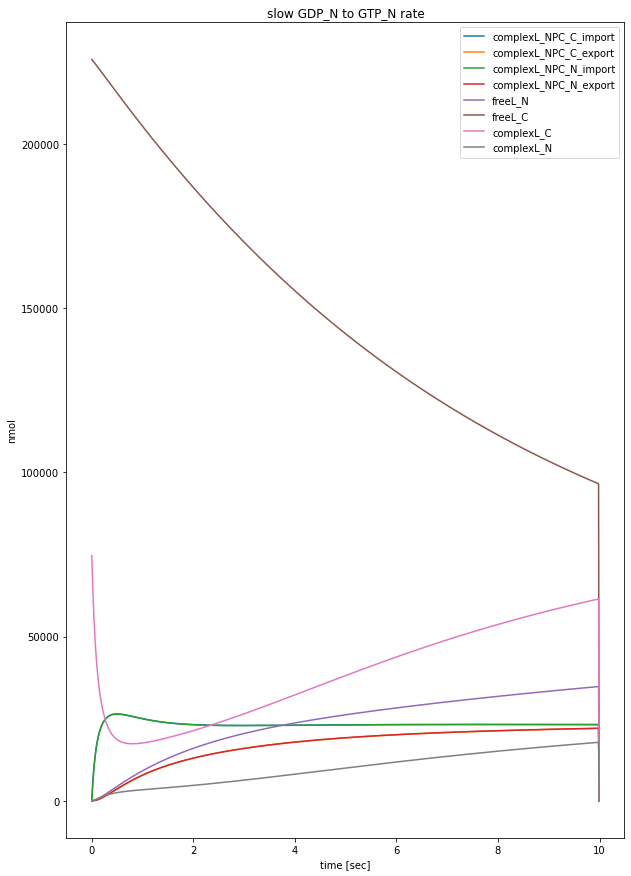

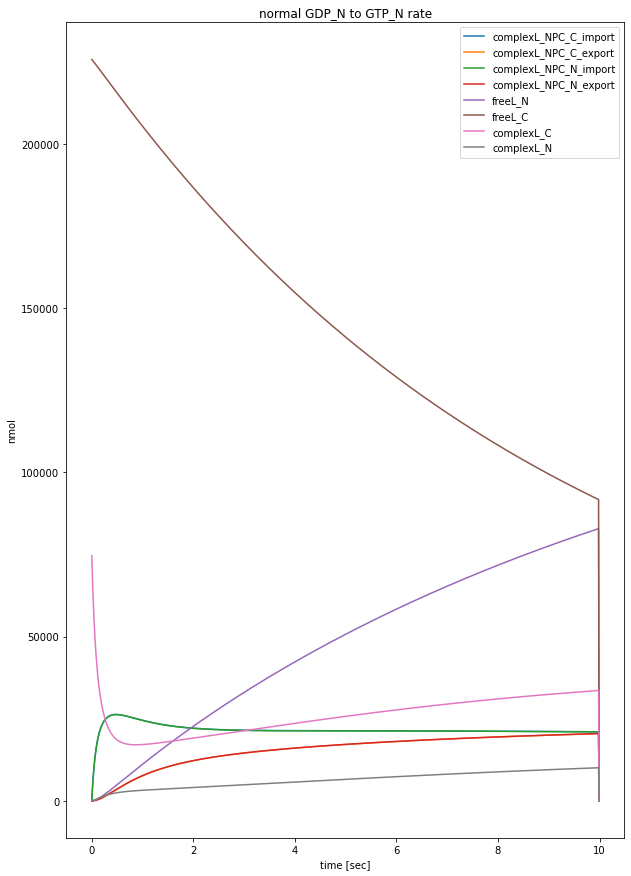

In [11]:

#fig, ax = plt.subplots(1, 3,figsize=(40,5))
axes0, x, c_1 = plot_simulation_attributes(sim_time_sec, 
                                   [cargoL_attributes], 
                                   log= is_log, rate_GDP_N_to_GTP_N_per_sec=0.2,
                                  dt_sec= 1e-3)
axes0[0,0].set_title("slow GDP_N to GTP_N rate")
axes1, x, c_2 = plot_simulation_attributes(sim_time_sec, [cargoL_attributes], 
                                   log= is_log,
                                  dt_sec= 1e-3)
axes1[0,0].set_title("normal GDP_N to GTP_N rate")
#fig, ax2= plt.subplots(1,1)
#ax2.plot(c_1[-1], label='rate_GDP_N_to_GTP_N_per_sec=0.2')
#ax2.plot(c_2[-1], label='rate_GDP_N_to_GTP_N_per_sec=200.0')
#ax2.set_title("complexL_N")
#ax2.legend()

## Map parameters phasespace of transport

In [12]:

def get_tau_passive_diffusion(nmol_per_sec_per_M, volume_L):
    ''' 
    This utility function computes tau for one-sided passive diffusion
    specified in number of molecules per second per M, given
    the volume from which the passive diffusion leaves
    '''
    global N_A
    gamma= nmol_per_sec_per_M/N_A/volume_L
    tau= 1.0/gamma
    return tau



In [13]:
def get_new_transport_simulation(**kwargs):
    ts= TransportSimulation(**kwargs)        
#    ts.set_params(rate_GDP_C_to_GDP_N_per_sec=7)   
    ts.set_params(dt_sec=1e-3)
    return ts

In [14]:
import multiprocessing

def mp_do_simulation(param_range, i, j, 
                     equilibration_time_sec):
    init_params= {"Ran_cell_M": 20e-6}
    nskip_statistics= 100
    my_ts= get_new_transport_simulation(**init_params)
    my_ts.set_params(
        max_passive_diffusion_rate_nmol_per_sec_per_M  = param_range["max_passive_diffusion_rate_nmol_per_sec_per_M"][i],
        rate_free_to_complex_per_sec = param_range["rate_free_to_complex_per_sec"][j])        
    stats = my_ts.simulate(equilibration_time_sec, nskip_statistics= 100)   
    return {"i":i, "j":j, "stats":stats}

def mp_handle_stats(stats_grids, mydicts):
    for mydict in mydicts:
        i= mydict["i"]
        j= mydict["j"]
        stats= mydict["stats"]
#        print("My Handle - ", i, j)
        for nmol_type in stats.keys():
            if nmol_type=="time_sec":
                continue
            try: 
                pass
                stats_grids[nmol_type][j, i]= stats[nmol_type][-1] # matrix is indexed row first 
            except KeyError:
                print(f"my_handle_stats - Key {nmol_type} not found")
            except IndexError as e:
                print(e)

def mp_handle_error(error):
    print("Error", error)
    
def map_param_grid_parallel(nx,
                   ny,
                   equilibration_time_sec= 150.0, # equilibration time per condition
                   initial_equilibration_time= 300.0, # relevant only if is_reset is False 
                   n_processors= 5
                  ):
    param_range={}
    print(f"nx={nx} ny={ny}")
    epsilon = 1e-9
    c_cargo_M= 50e-6 # TODO: fetch this from the simulation
    param_range["max_passive_diffusion_rate_nmol_per_sec_per_M"] = \
        np.logspace(2, #0.001+epsilon, 
                    5, #-epsilon, 
                    nx) / c_cargo_M # divided by 50E-6 to normalize by the initial cargo concentration # TODO: take the actual cargo concentration?
    param_range["rate_free_to_complex_per_sec"] = \
        np.logspace(-3, 
                    0, #-epsilon, 
                    ny)
    ts= get_new_transport_simulation()
    for key in param_range.keys():
        print("Param {:} default value is {:}".format(key, getattr(ts, key)))
    stats_grids = {}
    for nmol_type in ts.nmol.keys(): # TODO: add get_nmols()
        stats_grids[nmol_type]= np.ndarray((ny, nx)) # Row major - y coordinate goes first
    jobs_params= []
    for j in range(ny):
        for i in range(nx):
            jobs_params.append((param_range.copy(),
                                i,
                                j,
                                equilibration_time_sec))
    print("njobs={}".format(len(jobs_params)))
    callback_function = \
        lambda mydict: mp_handle_stats(stats_grids, mydict)
    pool= multiprocessing.Pool(processes= n_processors)
    results= pool.starmap_async(mp_do_simulation,
                               jobs_params,
                               callback= callback_function,
                               error_callback=mp_handle_error)
    results.wait()
    pool.close()
    pool.join()
    return param_range, stats_grids


In [15]:
ts = get_new_transport_simulation()

In [16]:
def get_N_to_C_ratios(stats_grids, v_N_L, v_C_L):
    ''' return N/C ratios from stats_grids computed in the previous cell'''
    nNs= stats_grids["complexL_N"]+stats_grids["freeL_N"]+stats_grids["complexU_N"]+stats_grids["freeU_N"] 
    nCs= stats_grids["complexL_C"]+stats_grids["freeL_C"]+stats_grids["complexU_C"]+stats_grids["freeU_C"]
    ratios= (nNs/v_N_L) / (nCs/v_C_L)
    return ratios

param_range, stats_grids= map_param_grid_parallel(nx= 6,
                                        ny= 13,
#                                       is_reset=True, 
                                        equilibration_time_sec= 100.0,
                                        n_processors=6)
ratios= get_N_to_C_ratios(stats_grids, 
                          v_N_L= ts.get_v_N_L(), 
                          v_C_L= ts.get_v_C_L())

nx=6 ny=13
Param max_passive_diffusion_rate_nmol_per_sec_per_M default value is 20000
Param rate_free_to_complex_per_sec default value is 0.1
njobs=78


In [17]:
print(param_range["max_passive_diffusion_rate_nmol_per_sec_per_M"])

[2.00000000e+06 7.96214341e+06 3.16978638e+07 1.26191469e+08
 5.02377286e+08 2.00000000e+09]


[1.e+05 1.e+06 1.e+07 1.e+08 1.e+09 1.e+10 1.e+11]


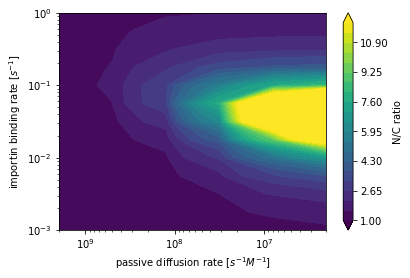

In [26]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
vmax=12
x_meshgrid, y_meshgrid = np.meshgrid(param_range["max_passive_diffusion_rate_nmol_per_sec_per_M"],
                                     param_range["rate_free_to_complex_per_sec"])

##### Contourf
plt.figure()
plt.contourf(x_meshgrid, y_meshgrid, ratios, vmin=1.0, vmax=vmax, levels=np.linspace(1.0,vmax,21), extend='both')
ax= plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r"passive diffusion rate [$s^{-1} M^{-1}$]")
ax.set_ylabel("importin binding rate [$s^{-1}$]")
xlim= ax.get_xlim()
ylim= ax.get_ylim()
ax.set_xlim(xlim[1], xlim[0])
print(ax.get_xticks())
cb = plt.colorbar(label="N/C ratio")
ticks = cb.get_ticks()
cb.set_ticks(ticks)




In [19]:
multiprocessing.cpu_count()

12

[1.e+05 1.e+06 1.e+07 1.e+08 1.e+09 1.e+10 1.e+11]
[1.e+05 1.e+06 1.e+07 1.e+08 1.e+09 1.e+10 1.e+11]


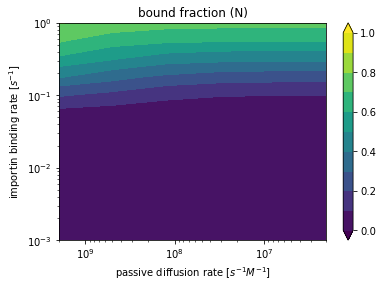

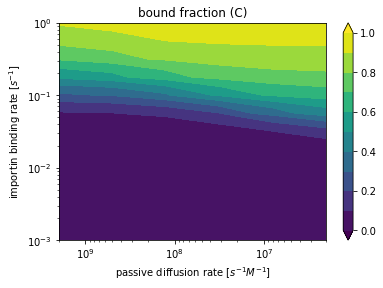

In [20]:
for compartment in ['N', 'C']:
    tag_complex= f"complexL_{compartment}"
    tag_free= f"freeL_{compartment}"
    complexL_fraction= stats_grids[tag_complex]/(stats_grids[tag_complex]+stats_grids[tag_free])
    ##### Contourf
    vmax=1.0
    plt.figure()
    plt.contourf(x_meshgrid, y_meshgrid, complexL_fraction, 
                 vmin=0.0, 
                 vmax=vmax, 
                 levels=np.linspace(0,vmax,11), 
                 extend='both')
    ax= plt.gca()
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r"passive diffusion rate [$s^{-1} M^{-1}$]")
    ax.set_ylabel("importin binding rate [$s^{-1}$]")
    xlim= ax.get_xlim()
    ylim= ax.get_ylim()
    ax.set_xlim(xlim[1], xlim[0])
    #ax.set_ylim(ylim[1], ylim[0])
    print(ax.get_xticks())
    
    cb = plt.colorbar()#label=f"bound fraction ({compartment})")
    ax.set_title(f"bound fraction ({compartment})")
    ticks = cb.get_ticks()
    cb.set_ticks(ticks)


# Map NLS strength, MW size, force

In [43]:
import numpy as np
import transport_simulation

def get_ts_parameters(MW= 27, 
                      NLS_strength= 0, 
                      is_force= False, 
                      **kwargs):
    ts = TransportSimulation(**kwargs)
    passive_diffusion_rate = get_diffusion_rate(MW, is_force)
    free_to_complex_rate = get_free_to_complex_rate(NLS_strength)
    ts.set_passive_diffusion_rate_per_sec(diffusion_rate)
    ts.set_params(rate_free_to_complex_per_sec=free_to_complex_rate)

    if is_force:
        force_effect = get_force_effect_on_import(MW, NLS_strength)
#        NPC_transport_rate = ts.fraction_complex_NPC_traverse_per_sec + force_effect
        NPC_transport_rate = ts.fraction_complex_NPC_traverse_per_sec + force_effect
        ts.set_params(fraction_complex_NPC_traverse_per_sec=NPC_transport_rate)
    return ts

def get_free_to_complex_rate(NLS_strength):
    rates = [0.0,
             0.002, #0.07
             0.02, #2.11
             0.2  #16.4
            ]
    return rates[NLS_strength]

def get_passiv_diffusion_rate(MW, is_force):
    #TODO: generalize this - either from the literature or regression
    base_rates={ 27:0.07624291, 
                41:0.0560286, 
                54:0.03452787, 
                67:0.03022162 }
    rate= base_rates[MW]
    if is_force:
        rate += get_force_effect_on_diffusion(MW)
    return rate

def get_force_effect_on_diffusion(MW):
    """
    The effect of force on passive diffusion as measured by experiment
    """
    effects = {27:0.08698999,
               41:0.03395035,
               54:-0.00019152,
               67:0.00177338}
    return effects[MW]

def get_force_effect_on_import(MW, NLS_strength):
    NPC_transport_rates = {}
    NPC_transport_rates[27] = [0, 0, 0.2, 0.5]
    NPC_transport_rates[41] = [0, 0, 0.2, 0.5]
    NPC_transport_rates[54] = [0, 0, 0.2, 0.5]
    NPC_transport_rates[67] = [0, 0, 0.2, 0.5]
    return NPC_transport_rates[MW][NLS_strength]


In [44]:
def get_compartment_nmol_stats(ts, 
                               stats, 
                               compartment):
    assert(compartment in ['N','C'])
    nframes= len(stats['time_sec'])
    nmol_stats= np.zeros(nframes)
    for state in ['free','complex']:
        for label in ['L','U']:
            tag= '{}{}_{}'.format(state, 
                                  label, 
                                  compartment)
            nmol_stats = nmol_stats + stats[tag]
    return nmol_stats

def get_compartment_concentration_stats(ts, 
                                        stats, 
                                        compartment):
    assert(compartment in ['N','C'])
    nmol_stats= get_compartment_nmol_stats(ts, 
                                           stats, 
                                           compartment)
    is_nuclear= (compartment=='N')
    volume_L= (ts.get_v_N_L() if is_nuclear else ts.get_v_C_L())
    return (nmol_stats/transport_simulation.N_A)/volume_L

def get_N_C_ratio_stats(ts, stats):
    EPSILON= 1E-12
    c_N_stats= get_compartment_concentration_stats(ts, 
                                                   stats, 
                                                   'N')
    c_C_stats= get_compartment_concentration_stats(ts, 
                                                   stats, 
                                                   'C')
    return c_N_stats/c_C_stats

Text(0, 0.5, 'N/C ratio')

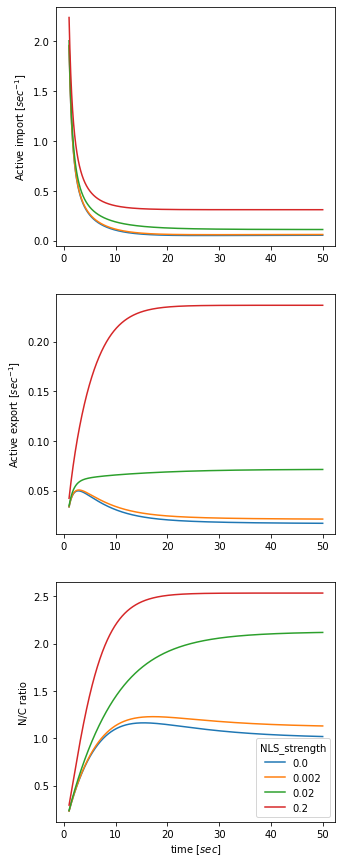

In [41]:
import matplotlib.pyplot as plt

fig, ax= plt.subplots(3, 1, figsize=(5,15))
for i in range(4):
    ts = get_ts_parameters(MW=41,
                            NLS_strength=i,
                          force= False)#, 
#                           fraction_complex_NPC_to_free_N_per_M_GTP_per_sec=1*0.005e6)
    ts.set_params(dt_sec=1e-3)
#    ts.bleach_start_time_sec= 100
    stats = ts.simulate(50)
    plot_from_sec= 1
    plot_from_frame= int(plot_from_sec/ts.dt_sec)
    x= stats['time_sec'][plot_from_frame:]
    ys={}
    ys[0]= stats['import_L'][plot_from_frame:]
    ys[1]= stats['export_L'][plot_from_frame:]
    ys[2]= get_N_C_ratio_stats(ts, stats)[plot_from_frame:]
    for j, cur_ax in enumerate(ax):
        cur_ax.plot(x, ys[j],
        label= get_free_to_complex_rate(i))
    cur_ax.set_xlabel(r"time [$sec$]")
    lh= cur_ax.legend()
    lh.set_title('NLS_strength')
ax[0].set_ylabel(r"Active import [$sec^{-1}$]")
ax[1].set_ylabel(r"Active export [$sec^{-1}$]")
ax[2].set_ylabel("N/C ratio")

Text(0, 0.5, 'N/C ratio')

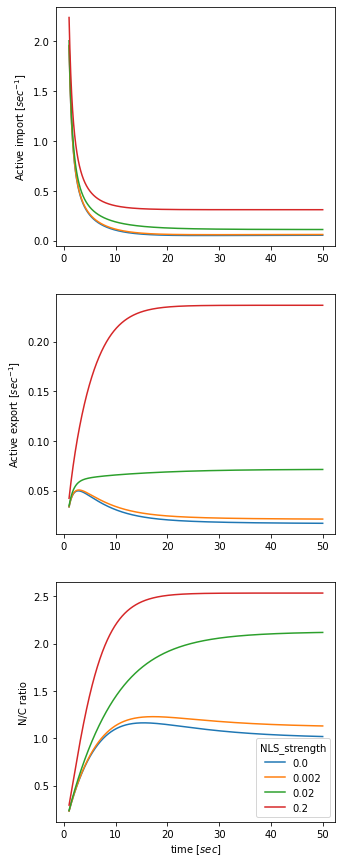

In [46]:
import matplotlib.pyplot as plt

fig, ax= plt.subplots(3, 1, figsize=(5,15))
for i in range(4):
    ts = get_ts_parameters(MW=41,
                            NLS_strength=i,
                          force= True)#, 
#                           fraction_complex_NPC_to_free_N_per_M_GTP_per_sec=1*0.005e6)
    ts.set_params(dt_sec=1e-3)
#    ts.bleach_start_time_sec= 100
    stats = ts.simulate(50)
    plot_from_sec= 1
    plot_from_frame= int(plot_from_sec/ts.dt_sec)
    x= stats['time_sec'][plot_from_frame:]
    ys={}
    ys[0]= stats['import_L'][plot_from_frame:]
    ys[1]= stats['export_L'][plot_from_frame:]
    ys[2]= get_N_C_ratio_stats(ts, stats)[plot_from_frame:]
    for j, cur_ax in enumerate(ax):
        cur_ax.plot(x, ys[j],
        label= get_free_to_complex_rate(i))
    cur_ax.set_xlabel(r"time [$sec$]")
    lh= cur_ax.legend()
    lh.set_title('NLS_strength')
ax[0].set_ylabel(r"Active import [$sec^{-1}$]")
ax[1].set_ylabel(r"Active export [$sec^{-1}$]")
ax[2].set_ylabel("N/C ratio")

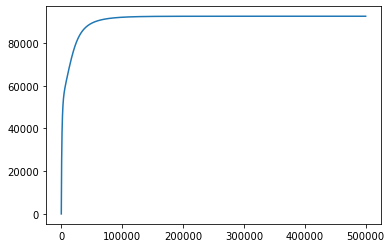

In [30]:
plt.plot(stats['complexL_NPC_N_import'] +
        stats['complexL_NPC_N_export'] +
        stats['complexL_NPC_C_import'] +
        stats['complexL_NPC_C_export'])

[1.e+05 1.e+06 1.e+07 1.e+08 1.e+09 1.e+10 1.e+11]
[1.e+05 1.e+06 1.e+07 1.e+08 1.e+09 1.e+10 1.e+11]


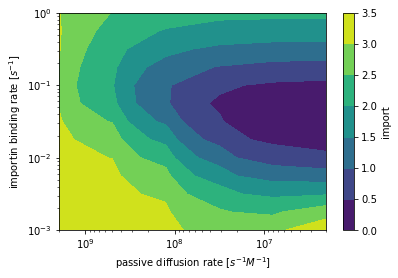

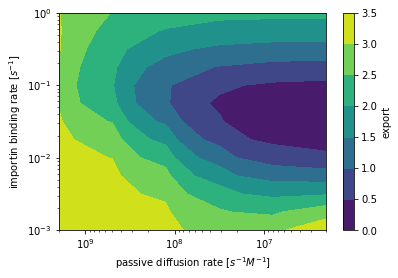

In [24]:
def get_import_export_ratios(stats_grids):
    ''' return import/export ratios from stats_grids computed in the previous cell'''
    import_rate= stats_grids["import_L"]+stats_grids["import_U"]
    export_rate= stats_grids["export_L"]+stats_grids["export_U"]
    ratios= import_rate/export_rate
    return ratios

ratios_import_export= get_import_export_ratios(stats_grids)
    
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
vmax=4
x_meshgrid, y_meshgrid = np.meshgrid(param_range["max_passive_diffusion_rate_nmol_per_sec_per_M"],
                                     param_range["rate_free_to_complex_per_sec"])
##### Contourf
for tag in ['import', 'export']:
    plt.figure()
    plt.contourf(x_meshgrid, 
                 y_meshgrid, 
#                 stats_grids[f'{tag}_U']+stats_grids[f'{tag}_U'])
                 ratios_import_export) #, vmin=1.0, vmax=vmax, levels=np.linspace(1.0,vmax,21), extend='both')
    ax= plt.gca()
    ax.set_xscale('log')
    ax.set_yscale('log')
    #ax.set_yscale('log')
    ax.set_xlabel(r"passive diffusion rate [$s^{-1} M^{-1}$]")
    ax.set_ylabel("importin binding rate [$s^{-1}$]")
    xlim= ax.get_xlim()
    ylim= ax.get_ylim()
    ax.set_xlim(xlim[1], xlim[0])
    #ax.set_ylim(ylim[1], ylim[0])
    print(ax.get_xticks())
    #ax.set_xticklabels(["{:.1f}".format(xtick) for xtick in param_range["max_passive_diffusion_rate_nmol_per_sec_per_M"]])
    #ax.set_yticklabels(["{:.2f}".format(ytick) for ytick in param_range["rate_free_C_to_complex_C_per_sec"]])
    cb = plt.colorbar(label=tag)
    ticks = cb.get_ticks()
    cb.set_ticks(ticks)

    #ax.xaxis.set_major_formatter(mtick.FormatStrFormatter("%.1f"))
    #ax.yaxis.set_major_formatter(mtick.FormatStrFormatter("%.1f"))

    #cb.set_ticklabels([f'{tick:.0e}' for tick in np.exp(ticks)])

